In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# Define a cleaning function for the dataset
def clean_fire_data(df):
    # Drop rows where essential columns like 'YEAR_' or 'GIS_ACRES' are missing
    df = df.dropna(subset=['YEAR_', 'GIS_ACRES'])
    
    # Convert 'YEAR_' to integer for easier analysis
    df.loc[:, 'YEAR_'] = df['YEAR_'].astype(int)  # Fixed SettingWithCopyWarning

    # Convert date columns to datetime for better handling
    for date_col in ['ALARM_DATE', 'CONT_DATE']:
        df.loc[:, date_col] = pd.to_datetime(df[date_col], errors='coerce')  # Fixed SettingWithCopyWarning
    
    # Drop columns with excessive missing data or limited utility
    columns_to_drop = ['COMMENTS', 'COMPLEX_NAME', 'IRWINID', 'COMPLEX_ID', 'FIRE_NUM']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])  # Avoid errors if columns don't exist

    # Fill missing 'AGENCY', 'UNIT_ID', and 'FIRE_NAME' with placeholder text
    df.loc[:, 'AGENCY'] = df['AGENCY'].fillna('Unknown')
    df.loc[:, 'UNIT_ID'] = df['UNIT_ID'].fillna('Unknown')
    df.loc[:, 'FIRE_NAME'] = df['FIRE_NAME'].fillna('Unnamed Fire')

    # Ensure other categorical columns have consistent formatting (e.g., string types)
    df.loc[:, 'STATE'] = df['STATE'].astype(str)

    return df

# Load the dataset
file_path = './Resources/California_Fire_Perimeters_(all).csv'
fire_data = pd.read_csv(file_path)

# Clean the dataset
cleaned_fire_data = clean_fire_data(fire_data)

# Save cleaned data to CSV file
cleaned_fire_data.to_csv("Resources/cleaned_fire_data.csv", index=False)

print("✅ Cleaned data successfully saved!")



✅ Cleaned data successfully saved!


In [21]:
import numpy as np
import pandas as pd

# Ensure ALARM_DATE and CONT_DATE are in datetime format
cleaned_fire_data['ALARM_DATE'] = pd.to_datetime(cleaned_fire_data['ALARM_DATE'], errors='coerce')
cleaned_fire_data['CONT_DATE'] = pd.to_datetime(cleaned_fire_data['CONT_DATE'], errors='coerce')

# Drop rows where ALARM_DATE or CONT_DATE are missing after conversion
cleaned_fire_data = cleaned_fire_data.dropna(subset=['ALARM_DATE', 'CONT_DATE'])

# Calculate containment duration in hours
cleaned_fire_data['Containment_Duration'] = (
    (cleaned_fire_data['CONT_DATE'] - cleaned_fire_data['ALARM_DATE']).dt.total_seconds() / 3600
)

# Remove invalid containment durations (zero or negative)
cleaned_fire_data = cleaned_fire_data[cleaned_fire_data['Containment_Duration'] > 0]

# Calculate effectiveness (handling divide-by-zero issues)
cleaned_fire_data['Effectiveness'] = cleaned_fire_data['GIS_ACRES'] / cleaned_fire_data['Containment_Duration']

# Replace infinite and negative infinite values with NaN
cleaned_fire_data['Effectiveness'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows where Effectiveness is NaN after calculations
cleaned_fire_data = cleaned_fire_data.dropna(subset=['Effectiveness'])

# Ensure C_METHOD is not missing before grouping
cleaned_fire_data = cleaned_fire_data.dropna(subset=['C_METHOD'])

# Define a mapping for C_METHOD to human-readable descriptions
c_method_mapping = {
    1: "Direct Attack (Hand Crews & Tools)",
    2: "Indirect Attack (Firebreaks & Barriers)",
    3: "Aerial Suppression (Planes & Helicopters)",
    4: "Backburning (Controlled Burns)",
    5: "Fireline Construction (Bulldozers & Trenching)",
    6: "Natural Barriers (Using Terrain Features)",
    7: "Mop-up (Extinguishing Hot Spots)",
    8: "Fire Shelter Deployment (Emergency Only)"
}

# Convert numeric C_METHOD to descriptions
cleaned_fire_data['C_METHOD_DESCRIPTION'] = cleaned_fire_data['C_METHOD'].map(c_method_mapping)

# Drop any rows where C_METHOD_DESCRIPTION is still NaN (invalid codes)
cleaned_fire_data = cleaned_fire_data.dropna(subset=['C_METHOD_DESCRIPTION'])

# Group by containment method and calculate mean effectiveness
method_effectiveness = cleaned_fire_data.groupby('C_METHOD_DESCRIPTION').agg(
    Average_Effectiveness=('Effectiveness', 'mean'),
    Count=('Effectiveness', 'count')
).sort_values(by='Average_Effectiveness', ascending=False)

# Display the results
print(method_effectiveness)




                                                Average_Effectiveness  Count
C_METHOD_DESCRIPTION                                                        
Aerial Suppression (Planes & Helicopters)                   22.065185    225
Mop-up (Extinguishing Hot Spots)                            21.092517    663
Indirect Attack (Firebreaks & Barriers)                     20.532006    454
Fire Shelter Deployment (Emergency Only)                    16.594689   1836
Fireline Construction (Bulldozers & Trenching)              14.559857     49
Natural Barriers (Using Terrain Features)                   11.021989    438
Backburning (Controlled Burns)                               9.448320     92
Direct Attack (Hand Crews & Tools)                           5.077024   1759


C:\Users\ntrie\AppData\Local\Temp\ipykernel_6256\1253462412.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_fire_data['Effectiveness'].replace([np.inf, -np.inf], np.nan, inplace=True)


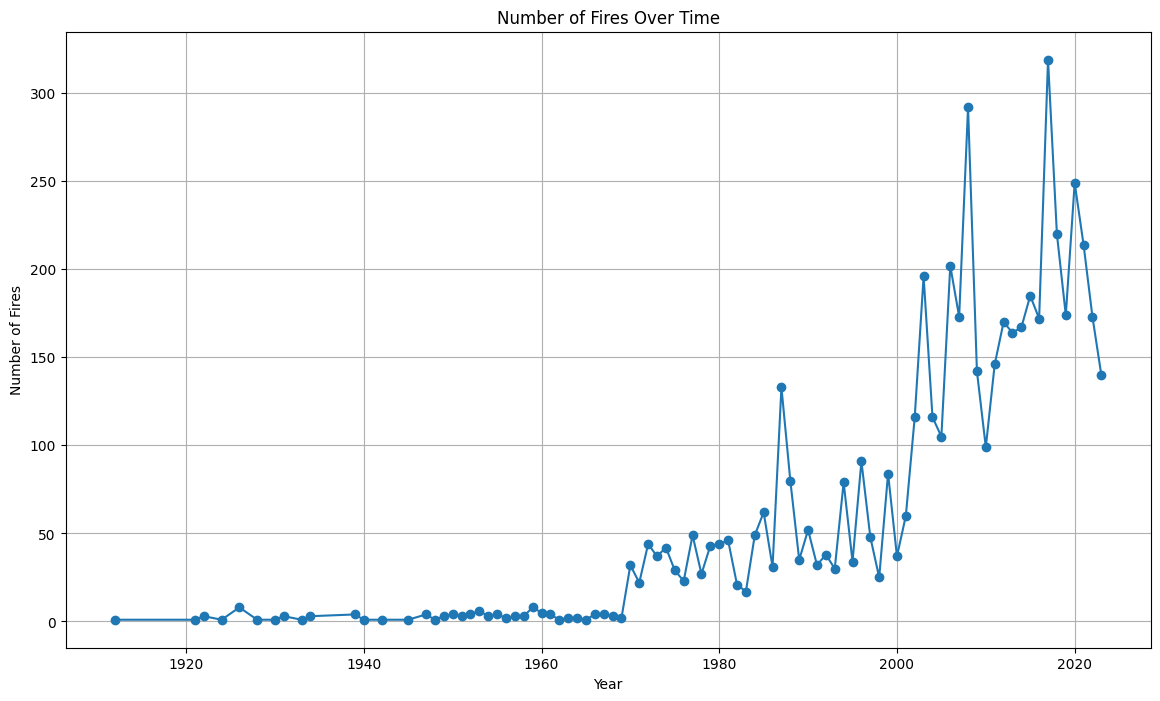

Peak Years for Fires:
YEAR_
2017.0    319
2008.0    292
2020.0    249
2018.0    220
2021.0    214
dtype: int64


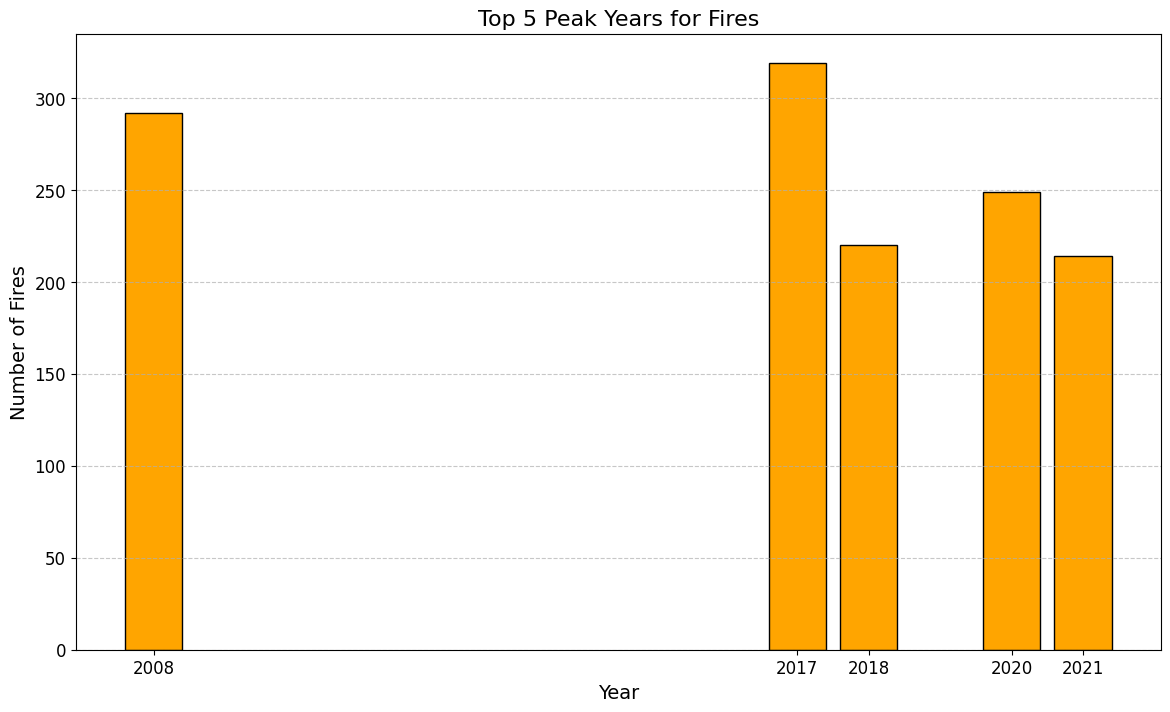

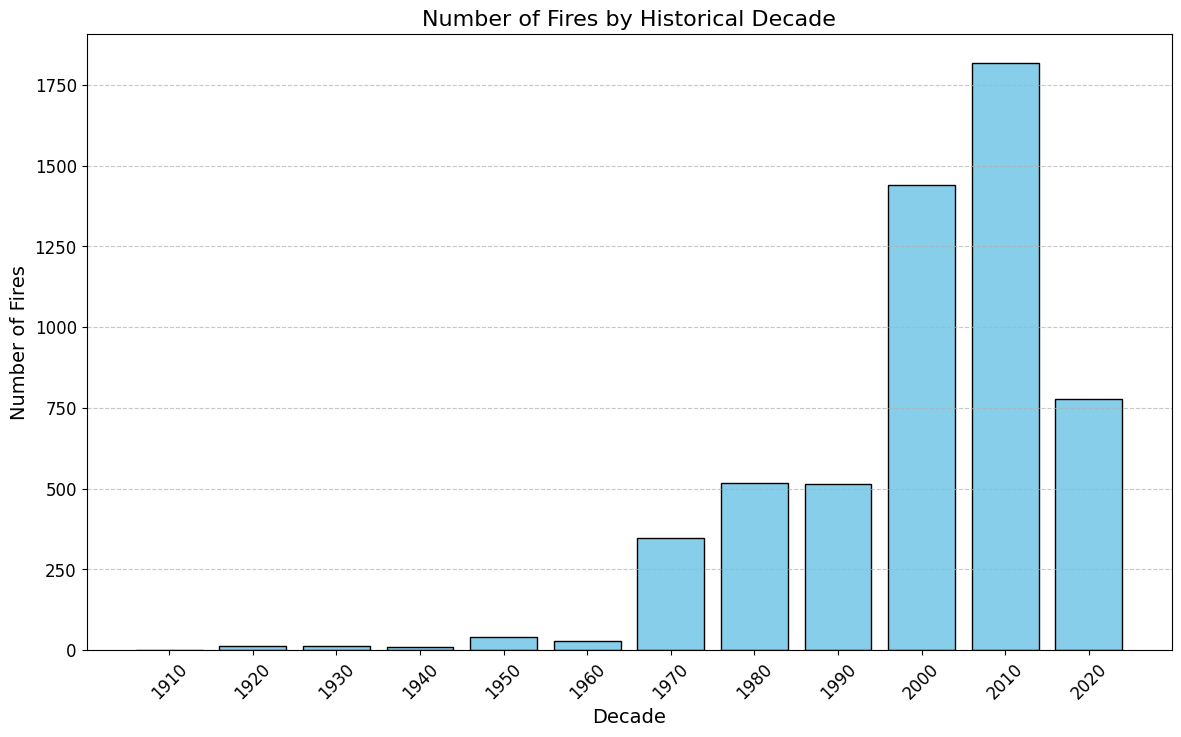

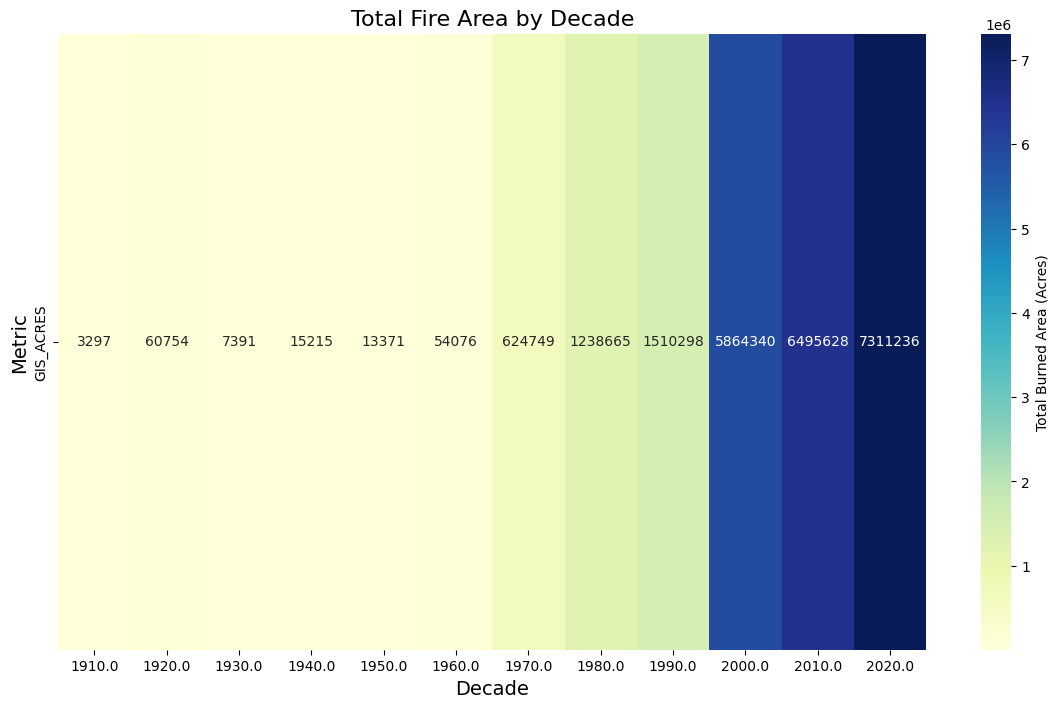

<class 'pandas.core.frame.DataFrame'>
Index: 5516 entries, 2 to 21833
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   OBJECTID              5516 non-null   int64              
 1   YEAR_                 5516 non-null   float64            
 2   STATE                 5516 non-null   object             
 3   AGENCY                5516 non-null   object             
 4   UNIT_ID               5516 non-null   object             
 5   FIRE_NAME             5516 non-null   object             
 6   INC_NUM               5196 non-null   object             
 7   ALARM_DATE            5516 non-null   datetime64[ns, UTC]
 8   CONT_DATE             5516 non-null   datetime64[ns, UTC]
 9   CAUSE                 5516 non-null   float64            
 10  C_METHOD              5516 non-null   float64            
 11  OBJECTIVE             5399 non-null   float64            
 12  GIS_ACRES 

In [22]:
# Plot the number of fires over time
fires_per_year = cleaned_fire_data.groupby('YEAR_').size()
plt.figure(figsize=(14, 8))
plt.plot(fires_per_year.index, fires_per_year.values, marker='o')
plt.title('Number of Fires Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.grid(True)
plt.savefig('./Resources/fires_over_time.png')
plt.show()

# Identify peak years for fires
peak_years = fires_per_year.sort_values(ascending=False).head(5)
print("Peak Years for Fires:")
print(peak_years)

# Plot the peak years for fires
peak_years_sorted = peak_years.sort_index()
plt.figure(figsize=(14, 8))
plt.bar(peak_years_sorted.index, peak_years_sorted.values, color='orange', edgecolor='black')
plt.title('Top 5 Peak Years for Fires', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Fires', fontsize=14)
plt.xticks(peak_years_sorted.index, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('./Resources/peak_years_for_fires.png')
plt.show()

# Plot the number of fires by decade
cleaned_fire_data['Decade'] = (cleaned_fire_data['YEAR_'] // 10) * 10
fires_by_decade = cleaned_fire_data.groupby('Decade').size()
plt.figure(figsize=(14, 8))
plt.bar(fires_by_decade.index, fires_by_decade.values, color='skyblue', edgecolor='black', width=8)
plt.title('Number of Fires by Historical Decade', fontsize=16)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Number of Fires', fontsize=14)
plt.xticks(fires_by_decade.index, fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('./Resources/fires_by_decade.png')
plt.show()

# Heatmap: Total fire area by decade
fire_area_by_decade = cleaned_fire_data.groupby('Decade')['GIS_ACRES'].sum().reset_index()
plt.figure(figsize=(14, 8))
sns.heatmap(fire_area_by_decade.set_index('Decade').T, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label': 'Total Burned Area (Acres)'})
plt.title('Total Fire Area by Decade', fontsize=16)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Metric', fontsize=14)
plt.savefig('./Resources/fire_area_by_decade.png')
plt.show()

# Display basic information
print(cleaned_fire_data.info())
print(cleaned_fire_data.head())




In [25]:
# Define mapping for fire cause codes to descriptions
cause_mapping = {
    1: "Lightning",
    2: "Equipment Use",
    3: "Smoking",
    4: "Campfire",
    5: "Debris Burning",
    6: "Railroad",
    7: "Arson",
    8: "Children",
    9: "Miscellaneous",
    10: "Fireworks",
    11: "Powerline",
    12: "Structure",
    13: "Escaped Prescribed Burn",
    14: "Unknown",
    15: "Vehicle",
    16: "Reburn",
    17: "Playing with Fire",
    18: "Miscellaneous Human Causes",
    19: "Other"
}

# Apply mapping to dataset
if 'CAUSE' in cleaned_fire_data.columns:
    cleaned_fire_data['CAUSE_DESCRIPTION'] = cleaned_fire_data['CAUSE'].map(cause_mapping)
    
    # Count occurrences of each cause
    cause_counts = cleaned_fire_data['CAUSE_DESCRIPTION'].value_counts()

    print("🔥 Cause Data Analysis:")
    print(cause_counts)
else:
    print("⚠️ Cause column is missing in the dataset.")

# Display basic information
print(cleaned_fire_data.info())
print(cleaned_fire_data[['CAUSE', 'CAUSE_DESCRIPTION']].drop_duplicates().dropna().head())


🔥 Cause Data Analysis:
CAUSE_DESCRIPTION
Lightning                     2025
Unknown                        863
Miscellaneous                  704
Equipment Use                  427
Arson                          403
Debris Burning                 245
Campfire                       225
Fireworks                      196
Powerline                      135
Smoking                        116
Children                        65
Miscellaneous Human Causes      51
Railroad                        30
Vehicle                         15
Reburn                           7
Other                            6
Structure                        2
Escaped Prescribed Burn          1
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 5516 entries, 2 to 21833
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   OBJECTID              5516 non-null   int64              
 1   YEAR_ 

c:\Users\ntrie\anaconda3\envs\my_dev\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


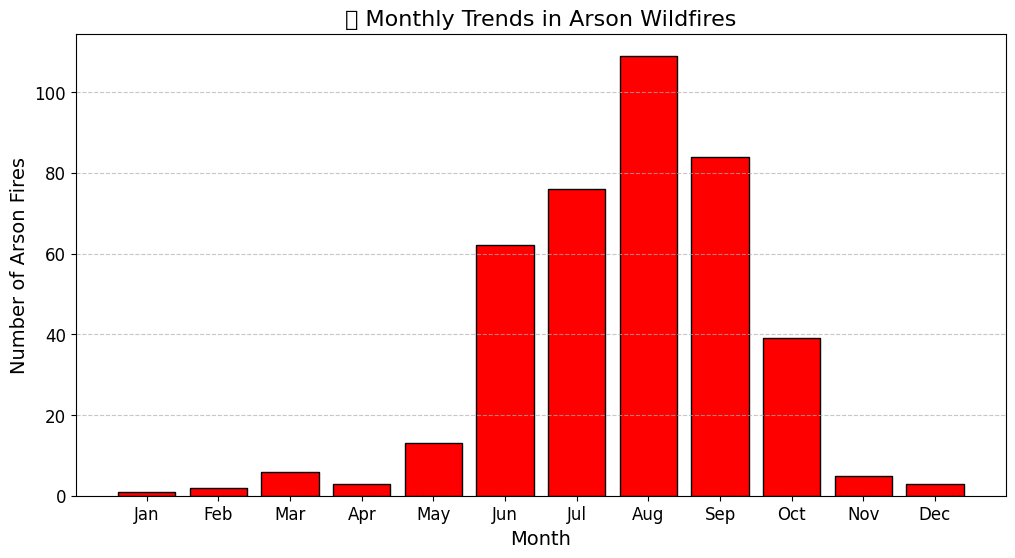

📌 Arson Fire Counts by Month:
Month
1       1
2       2
3       6
4       3
5      13
6      62
7      76
8     109
9      84
10     39
11      5
12      3
Name: count, dtype: int64


In [26]:
import matplotlib.pyplot as plt

# Ensure ALARM_DATE is in datetime format
cleaned_fire_data['ALARM_DATE'] = pd.to_datetime(cleaned_fire_data['ALARM_DATE'], errors='coerce')

# Extract month from ALARM_DATE
cleaned_fire_data['Month'] = cleaned_fire_data['ALARM_DATE'].dt.month

# Filter dataset for arson fires
arson_fires = cleaned_fire_data[cleaned_fire_data['CAUSE_DESCRIPTION'] == "Arson"]

# Count the number of arson fires per month
arson_by_month = arson_fires['Month'].value_counts().sort_index()

# 📊 Plot the number of arson fires per month
plt.figure(figsize=(12, 6))
plt.bar(arson_by_month.index, arson_by_month.values, color='red', edgecolor='black')
plt.xticks(range(1, 13), [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Arson Fires', fontsize=14)
plt.title('🔥 Monthly Trends in Arson Wildfires', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Display raw counts for verification
print("📌 Arson Fire Counts by Month:")
print(arson_by_month)


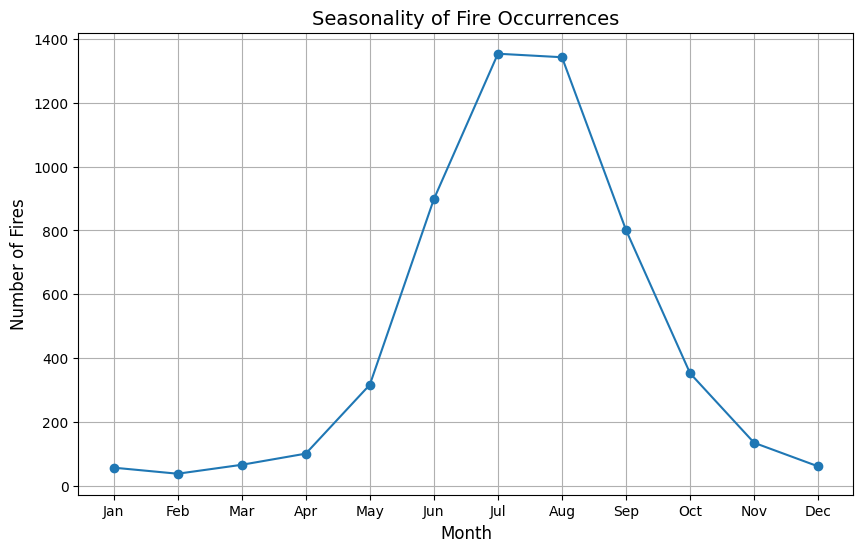

In [24]:
# Extract the month from the ALARM_DATE column
cleaned_fire_data['Month'] = cleaned_fire_data['ALARM_DATE'].dt.month

# Group by month and count the number of fires
fires_by_month = cleaned_fire_data.groupby('Month').size()

# Plot the seasonality
plt.figure(figsize=(10, 6))
plt.plot(fires_by_month.index, fires_by_month.values, marker='o')
plt.title('Seasonality of Fire Occurrences', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Fires', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.savefig('./Resources/seasonality.png')
plt.show()


c:\Users\ntrie\anaconda3\envs\my_dev\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


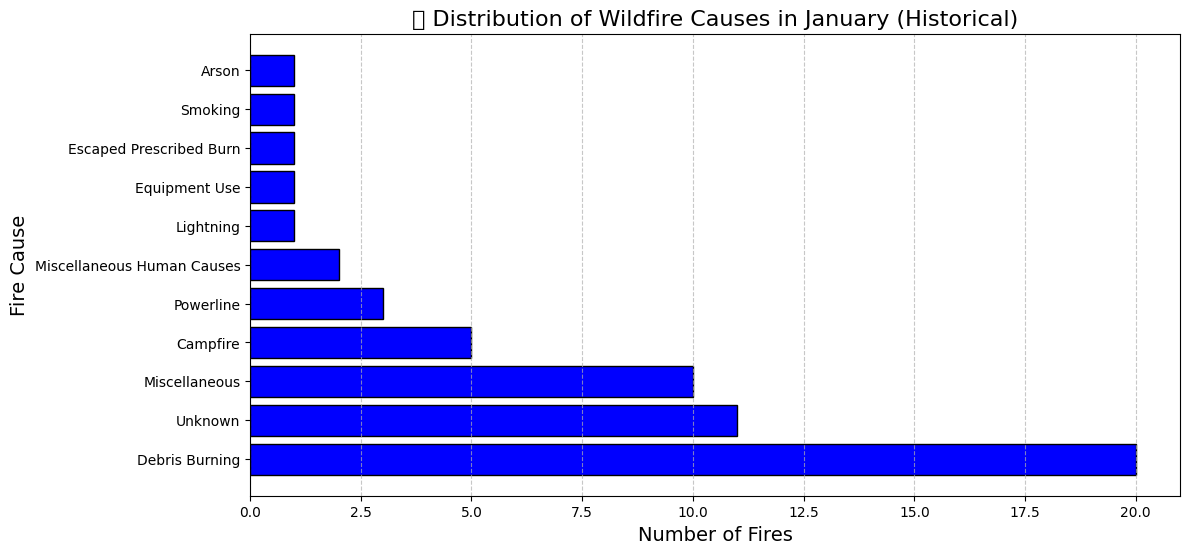

📌 Fire Causes in January (Historical):
CAUSE_DESCRIPTION
Debris Burning                20
Unknown                       11
Miscellaneous                 10
Campfire                       5
Powerline                      3
Miscellaneous Human Causes     2
Lightning                      1
Equipment Use                  1
Escaped Prescribed Burn        1
Smoking                        1
Arson                          1
Name: count, dtype: int64


In [27]:
import matplotlib.pyplot as plt

# Ensure ALARM_DATE is in datetime format
cleaned_fire_data['ALARM_DATE'] = pd.to_datetime(cleaned_fire_data['ALARM_DATE'], errors='coerce')

# Extract month from ALARM_DATE
cleaned_fire_data['Month'] = cleaned_fire_data['ALARM_DATE'].dt.month

# Filter dataset for fires occurring in January (Month = 1)
january_fires = cleaned_fire_data[cleaned_fire_data['Month'] == 1]

# Count the number of fires by cause
january_cause_distribution = january_fires['CAUSE_DESCRIPTION'].value_counts()

# 📊 Plot the distribution of fire causes in January
plt.figure(figsize=(12, 6))
plt.barh(january_cause_distribution.index, january_cause_distribution.values, color='blue', edgecolor='black')
plt.xlabel('Number of Fires', fontsize=14)
plt.ylabel('Fire Cause', fontsize=14)
plt.title('🔥 Distribution of Wildfire Causes in January (Historical)', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Display raw counts for verification
print("📌 Fire Causes in January (Historical):")
print(january_cause_distribution)


c:\Users\ntrie\anaconda3\envs\my_dev\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


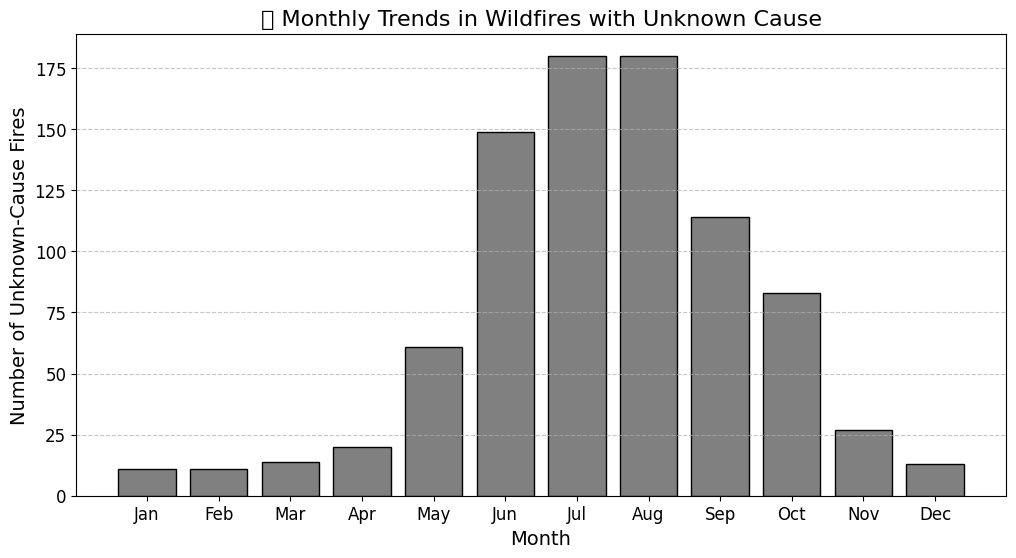

📌 Number of Unknown-Cause Fires by Month:
Month
1      11
2      11
3      14
4      20
5      61
6     149
7     180
8     180
9     114
10     83
11     27
12     13
Name: count, dtype: int64


In [28]:
import matplotlib.pyplot as plt

# Ensure ALARM_DATE is in datetime format
cleaned_fire_data['ALARM_DATE'] = pd.to_datetime(cleaned_fire_data['ALARM_DATE'], errors='coerce')

# Extract month from ALARM_DATE
cleaned_fire_data['Month'] = cleaned_fire_data['ALARM_DATE'].dt.month

# Filter dataset for fires with "Unknown" cause
unknown_fires = cleaned_fire_data[cleaned_fire_data['CAUSE_DESCRIPTION'] == "Unknown"]

# Count the number of unknown fires per month
unknown_by_month = unknown_fires['Month'].value_counts().sort_index()

# 📊 Plot the number of unknown fires per month
plt.figure(figsize=(12, 6))
plt.bar(unknown_by_month.index, unknown_by_month.values, color='gray', edgecolor='black')
plt.xticks(range(1, 13), [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Unknown-Cause Fires', fontsize=14)
plt.title('📊 Monthly Trends in Wildfires with Unknown Cause', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Display raw counts for verification
print("📌 Number of Unknown-Cause Fires by Month:")
print(unknown_by_month)
